# Genetic Algorithm - CW2

This code was created from scratch

### Install and import libaries 

In [69]:
# Install optproblems libary 

!pip install optproblems

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
# import libraries 

import numpy as np 
import statistics as stat
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import optproblems 
from optproblems import cec2005
from random import random 
from random import seed
from random import randint
import math

## Genetic Algorithm Class

This class contains the hyperparameters and functions required to perform the steps in the GA and some helper functions 

### Main functions 

The initial solutions are made by creating a list of random values and assigning that list as a phenome to an object of type individual. Each solution is the added to the list of solutions for the generation. 

The fitness of each soltuion is calculated by summing each element of the phenome and it's objective value and comparing it with that of the optimal solution. The absolute of the inverse of this value is then assigned as it's fitness value. This is to ensure the GA optimises both the objective value and the phenome to avoid getting trapped in local minima. 

Tournament selection is perfomed to obtain the parent solution for the next generation. Each parent solution is found by sampling a random selection of size k of the current generation and finding the solution with the best fitness value. 

One point cross over is used to create the new generation of solutions. The cross over rate is used to determine what percentage of new solutions will be generated by this method, with a high cross over rate meaning nore solutions generated using one point cross over. The cross over point of the solutions is generated randomly for each pair of parents. The random order of the list of parents allows the algorithm to perfrom cross over on parents which follow each other in the list. Once the cross over point is found the parents swap their parts around after this point to create the new child solutions. 

The new generation of child solutions are mutated at a random element within the phenome with a random value within the bounds of the problem. The mutation rate determines what percentage of the new child solutions are mutated. 

### Helper Functions

There is a helper function which finds the generation's best solution, it's fitness and the average fitness of all solutions in the generation. There is also a function which displays the solutions on a graph of the function when the dimetion of the solution is 2. 

In [71]:
# Genetic Algorithm Class 

class GA: 
  def __init__(self, popSize, solnSize, bound, k, mutProb, crsProb, func):     # Constructor
    
    self.popSize = popSize        # the population size of the generation 
    self.solnSize = solnSize      # the solution size for each solution in the generation
    self.bound = bound            # the upper/lower bound of the function
    self.k = k                    # the number of solutions used in a round of tournament selections
    self.mutProb = mutProb        # mutatation probability of a solution being mutated 
    self.crsProb = crsProb        # crossover probability of a child solution being generated by cross point selection 
    self.func = func              # the optproblems function 
    self.initGen = []             # the initial generation of solutions stored in a list
    self.currentGen = []          # the current generation of solutions stored in a list
    self.fitList = []             # the fitness values of the current generation of solutions in a list
    self.parentSel = []           # the list of parent solutions generated from tournament selection
    self.bestSoln = []            # the best solution's phenome stored in a list

    ans = self.func.get_optimal_solutions()     # get list of optimal solutions 
    optSoln = ans[0]                            # store first (and normally only?) optimal solution 
    self.func.evaluate(optSoln)                 # evaluate the optimal solution 
    self.optSoln = optSoln                      # store the optimal solution 


  def createGenOptLib(self):                  # create initial population of random solutions using the hyperparameters    
    self.initGen = []                                                 # reset the initial generation to be an empty list
    
    for i in range(self.popSize):                                     # for each member of the population
      soln = []                                                       # initialise list for a solution 
      for j in range(self.solnSize):                                  # for each element of the solution 
	      soln.append(round((random()*2*self.bound - self.bound), 4))   # generate a random number within the bounds of the problem with 4dp (like optproblems) 
      idiv = optproblems.Individual(soln)                             # create an instance of individual from optproblems with the solution generated above
      self.initGen.append(idiv)                                       # append the individual containing the solution as a phenome to the list of solutions

    self.currentGen = self.initGen                                    # store the initial solutions 
  

  def fitnessOptLib(self):                                  # assess the fitness of the functions 
    # fitness = 1/|(x + y + z + ... - t)| where t is the optimal coordinates x, y, z, ... summed 
    self.func.batch_evaluate(self.currentGen)               # evaluate z for the population 
    self.fitList = []                                       # ensure the list is empty 

    t = self.optSoln.objective_values                       # add value of z to the sum of the optimal solution's parts    
    for k in range(self.solnSize):                          # for each element in the optimal solution 
      t += self.optSoln.phenome[k]                          # add the element to the sum of the optimal solution's parts

    for i in range(self.popSize):                           # for each solution in the current generation 
      sum = self.currentGen[i].objective_values             # add value of z to the sum of the current solution's parts
      for j in range(self.solnSize):                        # for each element in the solution 
        sum += self.currentGen[i].phenome[j]                # add the element to the sum of the current solution's parts
      
      self.fitList.append(1/abs(sum - t))                   # calculate and store the solution's fitness to the list of fitness values 


  def tourSelOptLib(self):         # get a list of parent solutions using tournament selection 
    self.parentSel = []
    maxIndex = len(self.fitList)-1                            # calculate the maximum index value

    for j in range(self.popSize):                             # ensure the generation size stays the same by selecting the same number of parent soluntions  
      best = -1                                               # set the best fitness value to be negative 
      bestIndex = -1                                          # set the index which is used to get the fittest solution from the selection list
      newRandIndex = []                                       # list to remember which indexes have been used in the selection  
    
      for i in range(self.k):                                 # for each soln in selection k 
        index = randint(0, maxIndex)                          # get random soln index to pick a random solution
      
        if newRandIndex.count(index):                         # make sure there are no duplicate solutions in the selection
          i -= 1                                              # if there, go back and pick a new index 
        else:
          newRandIndex.append(index)                          # add index of this solution to list of indexes for this selection 
          if best <= self.fitList[index]:                     # checks if it is the fittest solution in the selection
            best = self.fitList[index]                        # makes it the new best fitness for this selection 
            bestIndex = index                                 # remembers the new best index for this selection
    
      self.parentSel.append(self.currentGen[bestIndex])       # add the best solution of the selection to list of parents 


  def onePtrCrsOptLib(self):                # perform one point cross over at a random point in each pair of solutions
    ng = []                                                 # list to hold children solutions

    for i in range(0, self.popSize-1, 2):                   # for each pair of parents
      crsPt = randint(0, self.solnSize-1)                    # generate a random crossover point 

      parent1 = self.parentSel[i].phenome                   # get first parent solution from solution list
      parent2 = self.parentSel[i+1].phenome                 # get seccond parent solution from solution list

      newStart1 = parent1[0:crsPt]                          # get start of first parent solution
      newStart2 = parent2[0:crsPt]                          # get start of second parent solution

      newEnd1 = parent1[crsPt::]                            # get end of first parent solution
      newEnd2 = parent2[crsPt::]                            # get end of second parent solution

      child1 = optproblems.Individual(newStart1 + newEnd2)  # create child with start of first parent and end of second parent
      child2 = optproblems.Individual(newStart2 + newEnd1)  # create child with start of second parent and end of first parent

      ng.append(child1)                                     # add new child to list of new child population
      ng.append(child2)                                     # add new child to list of new child population
      
    self.currentGen = ng                                    # update the current generation 


  def onePtrCrsOptLibProb(self):                # perform one point cross over at a random point in each pair of solutions
    ng = []                                                 # list to hold children solutions
    numCrsPt = int(self.mutProb * self.popSize)             # use the cross over rate to determine how many child solutions will be obtained 
    
    for i in range(0, numCrsPt-1, 2):                       # for each pair of parents
      crsPt = randint(0, self.solnSize-1)                   # generate a random crossover point 

      parent1 = self.parentSel.pop()                        # get first parent solution from solution list
      parent2 = self.parentSel.pop()                        # get seccond parent solution from solution list

      newStart1 = parent1.phenome[0:crsPt]                  # get start of first parent solution
      newStart2 = parent2.phenome[0:crsPt]                  # get start of second parent solution

      newEnd1 = parent1.phenome[crsPt::]                    # get end of first parent solution
      newEnd2 = parent2.phenome[crsPt::]                    # get end of second parent solution

      child1 = optproblems.Individual(newStart1 + newEnd2)  # create child with start of first parent and end of second parent
      child2 = optproblems.Individual(newStart2 + newEnd1)  # create child with start of second parent and end of first parent

      ng.append(child1)                                     # add new child to list of new child population
      ng.append(child2)                                     # add new child to list of new child population
       
    self.currentGen = ng + self.parentSel                   # update the current generation with the new child solutions and remaining parent solutions 


  def mutateOptLib(self):                       # mutate the new generation 
    for i in range(self.popSize):               # for each solution in the generation                                                                         
      self.currentGen[i].phenome[randint(0, self.solnSize-1)] = round((random()*2*self.bound - self.bound), 4) # assign a random value to a random element in the solution 


  def mutateOptLibProb(self):                       # mutate the new generation 
    numMutate = int(self.popSize * self.crsProb)    # use the mutation rate to get the amount of solutions to be mutated

    mutateSoln = []                                 # list to store mutated solutions 
    
    for i in range(numMutate):                                                                            # for each solution to be mutated
      mutateSoln.append(self.currentGen.pop(randint(0, len(self.currentGen)-1)))                          # add the solution to be mutated to the list and remove from the current generation 
      mutateSoln[i].phenome[randint(0, self.solnSize-1)] = round((random()*2*self.bound - self.bound), 4) # assign a random value to a random element in the solution

    self.currentGen = self.currentGen + mutateSoln  # add the mutated solutions to the remaining of the current generation


  def getBestSoln(self):                          # get the best soltion of the generation 
    self.fitnessOptLib()                          # get fitness of each solution in the generation 
    maxFit = max(self.fitList)                    # get the fittest value
    avgFit = sum(self.fitList)/len(self.fitList)
    maxFitIndex = self.fitList.index(maxFit)      # get the index of the fittest solution 
    
    self.bestSoln = self.currentGen[maxFitIndex]  # store the best solution ## Remove .phenome to calc better standard dev later??
    
    # print statements 
    print("The fittest solution was: ", self.bestSoln.phenome)   
    print("The optimal solution was: ", self.optSoln.phenome)

    print("Best fit was ", maxFit)
    print("Average fit was ", avgFit)
  

  def getBestSoln2(self):                         # get the best soltion of the generation 
    self.fitnessOptLib()                          # get fitness of each solution in the generation 
    maxFit = max(self.fitList)                    # get the fittest value
    avgFit = sum(self.fitList)/len(self.fitList)  # calculate the average fitness of the generation 
    maxFitIndex = self.fitList.index(maxFit)      # get the index of the fittest solution 
    
    self.bestSoln = self.currentGen[maxFitIndex]  # store the best solution ## Remove .phenome to calc better standard dev later??
    
    # print statements 
    #print("The fittest solution was: ", self.bestSoln.phenome)   
    #print("The optimal solution was: ", self.optSoln.phenome)

    #print("Best fit was ", maxFit)
    #print("Average fit was ", avgFit)

    return maxFit, avgFit


  def display(self):              # display the solution on a graph (iff solution size is 2) 

    boundT = 2*self.bound

    # initialise two 2D arrays to represent the x and y coordinates for the graph of the function from optproblems 
    x, y = np.array(np.meshgrid(np.linspace(-self.bound,self.bound,boundT), np.linspace(-self.bound,self.bound,boundT)))

    # creates a 2D array to store the function result to be graphed 
    z = np.zeros([boundT, boundT])


    for i in range(boundT):                                             # for every row 
      for j in range(boundT):                                           # for every element
        plotSoln = optproblems.Individual(np.array([x[i][j], y[i][j]])) # create a solution using the coordinates
        self.func.evaluate(plotSoln)                                    # evaluate the solution
        z[i][j] = plotSoln.objective_values                             # add the evaluation of the solution to z

    # set up arrays for scattering the first and final generations on the graph
    xFirst = np.zeros(self.popSize)                                          
    yFirst = np.zeros(self.popSize)
    xFinal = np.zeros(self.popSize) 
    yFinal = np.zeros(self.popSize)

    # get the coordinates for the first generation 
    for i in range(self.popSize):
      xFirst[i] = self.initGen[i].phenome[0]
      yFirst[i] = self.initGen[i].phenome[1]

    # get the coordinates for the last generation 
    for i in range(self.popSize):
      xFinal[i] = self.currentGen[i].phenome[0]
      yFinal[i] = self.currentGen[i].phenome[1]

    # get the coordinates of the optimal(smallest) point on the function
    x_min = x.reshape(-1)[z.argmin()]     # flatten the array of x coordinates and find the value with the same index as to the smallest value of z 
    y_min = y.reshape(-1)[z.argmin()]     # flatten the array of y coordinates and find the value with the same index as to the smallest value of z 

    # adjust the size of the plot in inches 
    plt.figure(figsize=(8,6))

    # plot the image of the function from optproblems within the bounds supplied 
    plt.imshow(z, extent=[-self.bound, self.bound, -self.bound, self.bound], origin='lower', cmap='PuBuGn', alpha=1)

    # display the colourbar to illustrate the depth (z)
    plt.colorbar()

    # plot the optimal solution with a black x
    plt.plot([x_min], [y_min], marker='x', markersize=5, color="yellow", label="Optimal")

    # plot the best solution with a black triange
    plt.plot(self.bestSoln.phenome[0], self.bestSoln.phenome[1], marker='^', markersize=5, color="yellow", label="Best")

    # plot the contours of the function 
    contours = plt.contour(x, y, z, colors='black', alpha=0.4)
    plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    # plot the coordinates which represent the solutions from the first generation 
    plt.scatter(xFirst, yFirst, 5, c="orange", label="first generation")

    # plot the coordinates which represent the solutions from the last generation   
    plt.scatter(xFinal, yFinal, 5, c="red", label="last generation")

    # show the legend
    plt.legend()

    # show the graph
    plt.show()




## Run Class

Thus class is used to run the GA class and calculate the standard devation and percentage error of the solutions. 

In [72]:
# Class used to run the genetic algorithm 

class Run():

  def run(self, maxGen, GA): 
    maxFitList = []
    avgFitList = []
    i = 0
    GA.createGenOptLib()         # create initial solution generation 
    
    while i<maxGen:  
      GA.fitnessOptLib()                  # assign fitness of solutions
      maxFit, avgFit = GA.getBestSoln2()  # get best and average fitness for the generation 
      maxFitList.append(maxFit)           # add to list of best fitness
      avgFitList.append(avgFit)           # add to list of average fitness
      GA.tourSelOptLib()                  # perform tournament selection 
      GA.onePtrCrsOptLib()                # perform one point cross over
      
      i += 1                              # increment counter 

      if GA.currentGen.count(GA.optSoln): # stop if optimum solution has been found
        print("soln found")
        GA.getBestSoln()
        break
      elif i==maxGen:                     # stop if max number of generations has been reached
        print("MAXIMUM NUMBER OF GENERATIONS REACHED")
        GA.getBestSoln()
        break

      GA.mutateOptLib()                   # mutate solutions 
    
    if GA.solnSize == 2:                  # display graph if applicable 
      GA.display()

    # display graph of average and best fitnesses 
      
    #print("best fit was ", max(maxFitList))
    #x = np.linspace(0,len(maxFitList)-1, len(maxFitList))
    #plt.plot(x, maxFitList, color="green", label = "best fitness")
    #plt.plot(x, avgFitList, color="red", label = "average fitness")
    #plt.legend()

    print("DONE")


  def runTen(self, maxGen, GA): 
    bestSolnList = []                   # list to store best solution from each run
    i = 0                     

    while i<10:                         # do ten runs 
      self.run(maxGen, GA)              # run the GA
      bestSolnList.append(GA.bestSoln)  # append this run's best solution to the list 
      i += 1
    
    # using solution phenome to obtain percentage error and standard devation

    stdSum = []                                 # list to store all elements of the same position in different solutions 
    stdAvg = np.zeros(GA.solnSize)              # array to store average value of an element at position i accross the best solutions 
    stdAcc = []                                 # list to store percentage error for each element position 
    resStdDev = []                              # list to calculate standard devation of each element position 

    for i in range(GA.solnSize):                  # for each element in the solution
      stdSum = []                                 # reset list
      for j in range(10):                         # for each GA run
        stdSum.append(bestSolnList[j].phenome[i]) # store the elements at position i of all solutions 
      stdAvg[i] = sum(stdSum)/len(stdSum)         # calculate the avergae of the element at position i
      stdAcc.append(abs((GA.optSoln.phenome[i] - stdAvg[i])/GA.optSoln.phenome[i]) * 100) # calculate percentage error of elements at position i
      resStdDev.append(stat.pstdev(stdSum))       # calculate standard devation of elements at position i
    
    perErr = sum(stdAcc)/len(stdAcc)             # calculate avg percentage error for all elements in solution 
    print("Avg percentage error for elements of solution is ", perErr)  # print
    
    avgStdDev = sum(resStdDev)/len(resStdDev)    # calculate avg standard deviation for all elements in solution 
    print("Avg standard deviation for elements of solution is ", avgStdDev) # print 



MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [78.3004, -44.3907]
The optimal solution was:  [81.0232, -48.395]
Best fit was  0.002362219509149003
Average fit was  0.0015730173653266065


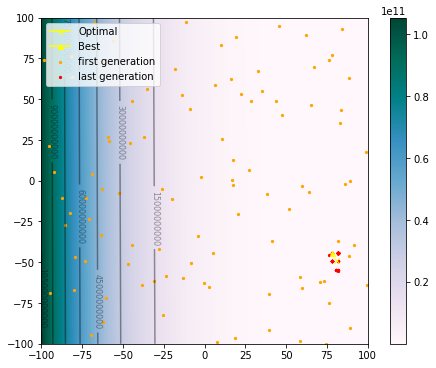

DONE


In [73]:
# run this cell with dimention 2 to display a 3d graph of the GA and the function 

funcMain = optproblems.cec2005.F6(2)
newGA = GA(popSize=100, solnSize=2, bound=100, k=100, mutProb=0.9, crsProb=0.9, func=funcMain)

Run().run(500, newGA)

In [74]:
# specify the dimention of the solutions
dim = 10

# specify the function from optproblems 
funcMain = optproblems.cec2005.F1(dim)

# Pass in the arguments for the GA class
newGA = GA(popSize=500, solnSize=dim, bound=100, k=50, mutProb=1, crsProb=1, func=funcMain)

# create an instance of the run class
r = Run()

# run 10 times with the specified maximum number of generations and the GA specified above
r.runTen(1000, newGA)


MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-40.0456, 58.7047, -47.9398, -74.6811, -16.7098, -81.2887, -10.72, 24.8867, 89.1073, 7.5259]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Best fit was  0.9331547909608542
Average fit was  0.08833153439878248
DONE
MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-39.0787, 58.358, -46.9544, -75.6704, -17.0981, -81.1689, -12.1343, 24.6718, 88.6388, 8.2934]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Best fit was  10.272269587106365
Average fit was  0.0998079175735918
DONE
MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-38.5699, 57.6899, -46.9876, -74.2316, -16.8614, -80.4189, -11.7734, 25.0101, 89.8825, 9.4719]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Be